In [9]:
import numpy as np
import matplotlib.pyplot as plt
from run import agents, run_agent, AgentStats
from numpy.typing import NDArray
from typing import NamedTuple, Sequence, Tuple
from deepsea import MultiRewardsDeepSea
import multiprocessing as mp
from scipy.stats import t as tstudent
import torch
from torch.multiprocessing import Pool, Process, set_start_method
try:
     set_start_method('spawn')
except RuntimeError:
    pass
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

class Results(NamedTuple):
    training_rewards: NDArray[np.float64]
    greedy_rewards: Sequence[Tuple[int, NDArray[np.float64]]]
    regret: NDArray[np.float64]
    agent_stats: AgentStats
    
    
def CE(x, c=0.95):
    N = x.shape[0]
    alpha = c + (1-c)/2
    c = tstudent.ppf(alpha, N)
    s = np.std(x, axis=0, ddof=1)
    return x.mean(0), c * s/ np.sqrt(N)

import pickle
data = {}
with open('data.pkl', 'rb') as f:
    data = pickle.load(f)
N_EPISODES = 2000
FREQ_EVAL_GREEDY =250
NUM_EVAL_GREEDY = 20
NUM_PROC = 4
NUM_RUNS = 8
SIZE = 20
MAX_REWARD = 1
SLIPPING_PROBABILITY = 0.05

In [10]:


# agent_name: str, seed: int, multi_rewards: bool, size: int, max_reward: float, slipping_probability: float,
#                 num_episodes: int, freq_val_greedy: int, num_eval_greedy:int):

with Pool(NUM_PROC) as pool:
    for multi_rewards in [False]:
        key_dict = f'multi_rewards_enabled_{multi_rewards}'
        if key_dict not in data:
            data[key_dict] = {}
        for agent_name in ['boot_dqn_torch', 'ids']:#::, 'explorative_generative_off_policy']:
            print(f'Running agent {agent_name} - multi_rewards {multi_rewards}')
            training_rewards, greedy_rewards, regret, stats = zip(*pool.starmap(
                run_agent, [(agent_name, idx, multi_rewards, SIZE, MAX_REWARD, SLIPPING_PROBABILITY, N_EPISODES, FREQ_EVAL_GREEDY, NUM_EVAL_GREEDY) for idx in range(NUM_RUNS)]))
            data[key_dict][agent_name] = Results(training_rewards, greedy_rewards, regret, stats)
 

Running agent boot_dqn_torch - multi_rewards False


Ep. 1999 - Regret: 629.63 - Last 10 ep. avg ret. 0.093 - Last greedy avg. ret. 0.192 (std 0.399): 100%|██████████| 2000/2000 [05:18<00:00,  6.27it/s] s]
Ep. 1999 - Regret: 557.545 - Last 10 ep. avg ret. 0.492 - Last greedy avg. ret. 0.393 (std 0.488): 100%|██████████| 2000/2000 [05:19<00:00,  6.25it/s]  
Ep. 1999 - Regret: 740.493 - Last 10 ep. avg ret. -0.001 - Last greedy avg. ret. -0.001 (std 0.001): 100%|██████████| 2000/2000 [05:23<00:00,  6.19it/s]
Ep. 1999 - Regret: 740.215 - Last 10 ep. avg ret. -0.001 - Last greedy avg. ret. -0.001 (std 0.0): 100%|██████████| 2000/2000 [05:25<00:00,  6.15it/s]
Ep. 1999 - Regret: 740.818 - Last 10 ep. avg ret. -0.001 - Last greedy avg. ret. -0.0 (std 0.001): 100%|██████████| 2000/2000 [05:36<00:00,  5.94it/s]  
Ep. 1999 - Regret: 740.316 - Last 10 ep. avg ret. -0.001 - Last greedy avg. ret. -0.0 (std 0.0): 100%|██████████| 2000/2000 [05:40<00:00,  5.88it/s]s]  
Ep. 1999 - Regret: 740.696 - Last 10 ep. avg ret. -0.002 - Last greedy avg. ret. -0.

Running agent ids - multi_rewards False


Ep. 1999 - Regret: 738.355 - Last 10 ep. avg ret. -0.001 - Last greedy avg. ret. -0.001 (std 0.001): 100%|██████████| 2000/2000 [09:29<00:00,  3.51it/s]
Ep. 1999 - Regret: 738.416 - Last 10 ep. avg ret. -0.002 - Last greedy avg. ret. -0.001 (std 0.001): 100%|██████████| 2000/2000 [09:29<00:00,  3.51it/s]
Ep. 1999 - Regret: 738.375 - Last 10 ep. avg ret. -0.001 - Last greedy avg. ret. -0.001 (std 0.0): 100%|██████████| 2000/2000 [09:33<00:00,  3.49it/s]
Ep. 1999 - Regret: 738.457 - Last 10 ep. avg ret. -0.001 - Last greedy avg. ret. -0.0 (std 0.0): 100%|██████████| 2000/2000 [09:35<00:00,  3.47it/s]  
Ep. 1999 - Regret: 738.527 - Last 10 ep. avg ret. -0.001 - Last greedy avg. ret. -0.0 (std 0.001): 100%|██████████| 2000/2000 [09:02<00:00,  3.68it/s]  
Ep. 1999 - Regret: 738.452 - Last 10 ep. avg ret. -0.002 - Last greedy avg. ret. -0.0 (std 0.0): 100%|██████████| 2000/2000 [09:05<00:00,  3.67it/s]s]
Ep. 1999 - Regret: 738.666 - Last 10 ep. avg ret. -0.001 - Last greedy avg. ret. -0.0 (s

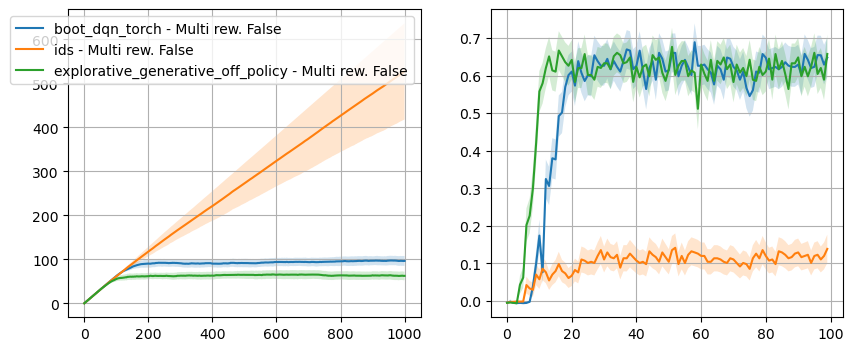

In [6]:
styles = {
    True: '--',
    False: '-'
}
fig, ax = plt.subplots(1,2, figsize=(10,4))

for multi_rewards in [False]:
    for agent_name in ['boot_dqn_torch', 'ids','explorative_generative_off_policy']:
        agent_data = data[f'multi_rewards_enabled_{multi_rewards}'][agent_name]
        mu, ce = CE(np.array(agent_data.regret))

        t = np.arange(N_EPISODES + 1)
        ax[0].plot(t, mu, label=f'{agent_name} - Multi rew. {multi_rewards}', linestyle=styles[multi_rewards])
        ax[0].fill_between(t, np.clip(mu-ce,0,np.infty), mu+ce, alpha=0.2)
        
        greedy_data = np.array([list(zip(*agent_data.greedy_rewards[x]))[1] for x in range(NUM_RUNS)])

        mu, ce = CE(greedy_data.swapaxes(1,2).reshape(-1, greedy_data.shape[1]))
        x = range(len(mu))
        ax[1].plot(x, mu, linestyle=styles[multi_rewards])
        ax[1].fill_between(x, np.clip(mu-ce,0, np.infty), mu+ce, alpha=0.2)

ax[0].grid()
ax[1].grid()
ax[0].legend()

In [11]:
N_EPISODES = 1000
FREQ_EVAL_GREEDY = 100
NUM_EVAL_GREEDY = 20
NUM_PROC = 4
NUM_RUNS = 8
SIZE = 20
MAX_REWARD = 1
SLIPPING_PROBABILITY = 0.05

# agent_name: str, seed: int, multi_rewards: bool, size: int, max_reward: float, slipping_probability: float,
#                 num_episodes: int, freq_val_greedy: int, num_eval_greedy:int):

with Pool(NUM_PROC) as pool:
    for multi_rewards in [True,False]:
        key_dict = f'multi_rewards_enabled_{multi_rewards}'
        if key_dict not in data:
            data[key_dict] = {}
        for agent_name in ['explorative_generative_off_policy']:
            print(f'Running agent {agent_name} - multi_rewards {multi_rewards}')
            training_rewards, greedy_rewards, regret, stats = zip(*pool.starmap(
                run_agent, [(agent_name, idx, multi_rewards, SIZE, MAX_REWARD, SLIPPING_PROBABILITY, N_EPISODES, FREQ_EVAL_GREEDY, NUM_EVAL_GREEDY) for idx in range(NUM_RUNS)]))
            data[key_dict][agent_name] = Results(training_rewards, greedy_rewards, regret, stats)
 

Running agent explorative_generative_off_policy - multi_rewards True


Ep. 999 - Regret: 80.749 - Last 10 ep. avg ret. 0.896 - Last greedy avg. ret. 0.844 (std 0.357): 100%|██████████| 1000/1000 [09:35<00:00,  1.74it/s]  
Ep. 999 - Regret: 309.89 - Last 10 ep. avg ret. 0.893 - Last greedy avg. ret. 0.743 (std 0.433): 100%|██████████| 1000/1000 [09:37<00:00,  1.73it/s]
Ep. 999 - Regret: 116.449 - Last 10 ep. avg ret. 0.993 - Last greedy avg. ret. 0.793 (std 0.4): 100%|██████████| 1000/1000 [09:38<00:00,  1.73it/s] 
Ep. 999 - Regret: 192.207 - Last 10 ep. avg ret. 0.795 - Last greedy avg. ret. 0.847 (std 0.357): 100%|██████████| 1000/1000 [09:45<00:00,  1.71it/s]
Ep. 311 - Regret: 55.149 - Last 10 ep. avg ret. 0.992 - Last greedy avg. ret. 0.942 (std 0.218):  31%|███       | 312/1000 [03:04<06:43,  1.70it/s]/home/alessior/rl-exploration-maze/DeepSea/agents/explorative_generative_off_policy.py:306: RuntimeWarning: invalid value encountered in divide
  p = (H/H.sum(-1, keepdims=True))
Ep. 317 - Regret: 39.059 - Last 10 ep. avg ret. 0.894 - Last greedy avg. re

ValueError: probabilities contain NaN

In [3]:
import pickle
with open('data.pkl', 'wb') as f:
    pickle.dump(data, f)

In [ ]:
greedy_data = np.array([list(zip(*data['multi_rewards_enabled_False']['boot_dqn_torch'].greedy_rewards[x]))[1] for x in range(NUM_RUNS)])

mu_groups, std_groups = greedy_data.mean(-1), greedy_data.std(-1, ddof=1)
RSS, ESS = std_groups.mean(0), mu_groups.std(0, ddof=1)
mu, std = mu_groups.mean(0), RSS+ESS


alpha = .95 + (1-.95)/2
c = tstudent.ppf(alpha, 5)
se = c * std/ np.sqrt(5)

x = range(len(mu))
plt.plot(x, mu)
plt.fill_between(x, np.clip(mu-se,0, np.infty), mu+se, alpha=0.2)

#plt.plot(x, ESS)

KeyError: 'multi_rewards_enabled_False'